In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
llm = ChatOpenAI(model="gpt-4o")

In [3]:
# Schema for structured output
from pydantic import BaseModel, Field
from langchain_community.tools import TavilySearchResults


# Define a tool
tavily_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([tavily_tool])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke(
    "nvidia 주가 하락의 원인이 된 대상 이름이 뭐야?그리고 그 대상에 대한 정보 알려줘"
)

# Get the tool call
msg.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'NVIDIA 주가 하락 원인 2023'},
  'id': 'call_WcQyfUD0p4SKinQoxw6M3kTR',
  'type': 'tool_call'}]

In [14]:
from pprint import pprint
pprint(msg)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WcQyfUD0p4SKinQoxw6M3kTR', 'function': {'arguments': '{"query":"NVIDIA 주가 하락 원인 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 103, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7bddc39b-0677-45b1-8a9f-3877e9eed1b0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'NVIDIA 주가 하락 원인 2023'}, 'id': 'call_WcQyfUD0p4SKinQoxw6M3kTR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 103, 'output_tokens': 29, 'total_tokens': 132, 'input_token_details': {'audio': 0, 'cache_rea

In [4]:
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph, START, END
# from IPython.display import Image, display


# class SearchQury(BaseModel):
#     search_query: str = Field(
#         None, description="Query that is optimized for web search."
#     )
#     justification: str = Field(
#         None, description="Why query is relevant to the user's request."
#     )


# class Reference(BaseModel):
#     """Model for a reference"""

#     title: str = Field(description="The title of the reference.")
#     url: str = Field(description="The url of the reference.")


# # Graph state
# class State(TypedDict):
#     search_queries: list[SearchQury]
#     combined_output: str



In [5]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

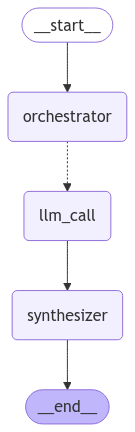

In [7]:
from langgraph.constants import Send
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
checkpointer = MemorySaver()

orchestrator_worker = orchestrator_worker_builder.compile(checkpointer=checkpointer)

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [8]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔹 Node: \033[1;34m{curr_node}\033[0m 🔹")
                    print("=" * 60)

                # 콘텐츠를 보기 좋게 출력
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node

In [9]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("=" * 60)

                # 쿼리 정보가 있으면 출력
                tool_calls = chunk_msg.additional_kwargs.get("tool_calls", [])
                if tool_calls:
                    # print(f"🔍 Query: ", end="")
                    for tool_call in tool_calls:
                        query = tool_call.get("function", {}).get("arguments", "")
                        if query:

                            print(f"{query}", end="", flush=True)
                else:
                    # 쿼리 정보가 없으면 content 출력
                    content = chunk_msg.content
                    if content:
                        print(f"{content}", end="", flush=True)

            prev_node = curr_node

In [10]:
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
}

inputs = State(
    topic="Create a report on LLM scaling laws",
    sections = [],
    completed_sections = [],
    final_report = ""
    
)

In [11]:
await astream_graph(orchestrator_worker, inputs, config=config)


🔄 Node: orchestrator 🔄
{"sections":[{"name":"Introduction to LLM Scaling Laws","description":"This section will provide an overview of what LLM (Large Language Models) scaling laws are, their importance in the development of AI models, and how they influence model performance and efficiency."},{"name":"Historical Context and Development","description":"This section will cover the history and evolution of scaling laws in the context of language models, highlighting key research papers and breakthroughs that have shaped our current understanding."},{"name":"Mathematical Foundation of Scaling Laws","description":"This section will delve into the mathematical principles and theories that underpin scaling laws, including key formulas and models used to predict model performance based on size and computational resources."},{"name":"Impact on Model Design and Architecture","description":"This section will explore how scaling laws affect the design and architecture of language models, includi

In [12]:
from IPython.display import Markdown

Markdown(orchestrator_worker.get_state(config).values["final_report"])

## Introduction to LLM Scaling Laws

Large Language Models (LLMs) are a cornerstone of modern artificial intelligence, fundamentally transforming how machines process and generate human language. A critical concept underpinning the development of these models is LLM scaling laws, which describe how changes in the size of a model—specifically, its parameters, data, and computational resources—affect its performance and capabilities.

### Understanding Scaling Laws

Scaling laws in the context of LLMs refer to the empirical relationships that dictate how improvements in AI models can be achieved by increasing their scale. These laws are formulated based on extensive experimentation and analysis, revealing that model performance tends to improve predictably as we scale up three key factors:

1. **Model Size (Parameters):** Increasing the number of parameters generally enhances a model's ability to understand and generate complex language patterns. This expansion allows for richer representations of language intricacies and nuanced context handling.

2. **Dataset Size:** As the volume of training data increases, models are better able to generalize from diverse linguistic inputs. More extensive datasets provide a broader base of examples from which the model can learn, thereby improving its accuracy and adaptability.

3. **Compute Resources:** Greater computational power enables more sophisticated training processes, allowing models to leverage increased parameters and data effectively. Enhanced compute capabilities facilitate more iterations, finer-tuned training, and ultimately, better optimization of model parameters.

### Importance of Scaling Laws

The importance of LLM scaling laws lies in their ability to guide the efficient development and deployment of AI models. By understanding these relationships, researchers and developers can make informed decisions about resource allocation, balancing the trade-offs between model complexity, training duration, and performance outcomes. Scaling laws offer a blueprint for predicting performance gains from scaling up resources, helping to optimize model architecture and training strategies.

Moreover, these laws highlight the diminishing returns associated with certain scaling aspects, prompting the exploration of innovative techniques to achieve further advancements. For instance, while increasing the model size can enhance performance, it also demands more computational power and memory, which may not always be feasible or cost-effective. Thus, scaling laws push the AI community to seek alternative methods, such as model compression or fine-tuning, to maintain efficiency while scaling.

### Influence on Model Performance and Efficiency

LLM scaling laws significantly influence the performance and efficiency of AI models. By adhering to these principles, developers can produce models that not only perform exceptionally well on complex language tasks but also do so with optimal resource usage. This is crucial as LLMs are deployed in a wide range of applications, from natural language processing and machine translation to customer service automation and content creation.

In summary, LLM scaling laws provide essential insights into the systematic scaling of AI models, presenting a framework for enhancing performance while managing resource constraints. As the field of AI continues to evolve, these laws will remain a pivotal factor in steering the development of increasingly sophisticated and capable language models.

---

## Historical Context and Development

The exploration of scaling laws in language models has been instrumental in shaping our understanding of how model performance can be improved through changes in scale. The journey began with the broader development of artificial neural networks, which saw a resurgence due to increased computational power and data availability in the late 2000s.

### Early Developments

The roots of scaling laws can be traced back to the pioneering work on neural network architectures and the introduction of backpropagation in the 1980s. However, it wasn't until the introduction of deep learning frameworks and the availability of large datasets that researchers could experiment with larger models. Initial efforts focused on empirical observations that suggested larger models tended to perform better, albeit with diminishing returns.

### Breakthrough Papers

One of the seminal papers that discussed scaling in the context of deep learning was "Understanding Deep Learning Requires Rethinking Generalization" by Zhang et al. (2016). This study highlighted the surprising generalization capabilities of neural networks, setting the stage for questioning the limits of scaling.

The paradigm shift occurred with the advent of the Transformer architecture, introduced by Vaswani et al. in 2017. This architecture demonstrated unprecedented scalability and performance in natural language processing tasks, leading to a flurry of research on scaling laws. The paper "Attention is All You Need" not only introduced the transformer but also showcased the potential of scaling model parameters to improve language understanding.

### Evolution of Scaling Laws

In 2020, Kaplan et al. published a pivotal paper, "Scaling Laws for Neural Language Models," which provided a formal investigation into how model performance changes with scale. They identified power-law relationships between model size, the amount of training data, and compute, offering a predictive framework for model scaling. This paper was crucial in providing a theoretical underpinning for the empirical observations gathered over the years.

Subsequent research focused on refining these laws and addressing challenges associated with scaling, such as training efficiency and the environmental impact of larger models. The work by Brown et al. on GPT-3 in 2020 further exemplified the application of scaling laws, showcasing how significantly larger models could achieve superior performance across a wide range of tasks without task-specific fine-tuning.

### Current Understanding

Today, scaling laws are a cornerstone of language model development, guiding both academic research and industry applications. The continuous growth in model size, from GPT-2 to GPT-4 and beyond, embodies the principles outlined by scaling laws, driving innovations in model architecture, training techniques, and optimization strategies.

The historical development of scaling laws reflects a broader trend in deep learning: the iterative process of empirical discovery, theoretical formulation, and practical application. As computational resources continue to expand, scaling laws remain a vital area of research, promising further advancements in the capability and accessibility of language models.

---

## Mathematical Foundation of Scaling Laws

Scaling laws are an essential concept in understanding how the performance of machine learning models changes with size and computational resources. They provide a framework for predicting how adjustments in these factors impact the efficiency and accuracy of models. This section explores the mathematical principles and theories that form the basis of these scaling laws, alongside key formulas and models that facilitate these predictions.

### Key Concepts and Theories

Scaling laws are fundamentally rooted in statistical learning theory, which seeks to understand the relationship between model complexity, data size, and generalization performance. The principle of Occam's razor often guides this understanding, suggesting that simpler models tend to generalize better if they are sufficiently expressive.

Another critical concept is the bias-variance tradeoff, which describes how increasing model complexity can reduce bias but increase variance. Scaling laws help quantify these effects, providing insights into how model size and training data can be balanced for optimal performance.

### Important Formulas and Models

1. **Power Law**: A fundamental mathematical model used in scaling laws is the power law, expressed as:

   \[
   P(n) = C \times n^\alpha
   \]

   where \(P(n)\) is the model performance, \(n\) is a measure of model size or computational effort, \(C\) is a constant, and \(\alpha\) is a scaling exponent that determines how performance scales with size.

2. **Law of Diminishing Returns**: This is often observed in scaling laws, where as models increase in size, the gains in performance decrease. Mathematically, this is expressed through sub-linear scaling, where \(\alpha < 1\).

3. **Learning Curves**: These are graphical representations that show the relationship between the size of the training dataset and the performance of a model. The asymptotic nature of these curves often follows a power law, indicating that performance improvements decrease with larger datasets.

4. **Compute-Optimal Scaling Laws**: These laws aim to identify the most efficient use of computational resources for training models. The compute-optimal scaling law is often represented as:

   \[
   L \propto N^{-\beta}
   \]

   where \(L\) is the loss, \(N\) is the computation (often measured in floating-point operations), and \(\beta\) is the scaling exponent reflecting how loss decreases with increased computation.

### Predictive Models

Researchers often employ predictive models to forecast the scaling behavior of machine learning systems. One such model is the neural scaling law, which predicts the performance of neural networks based on parameters, dataset size, and training compute. These models are invaluable for guiding the design and deployment of large-scale AI systems, ensuring that resources are used effectively to achieve desired performance levels.

### Implications and Applications

Understanding the mathematical foundation of scaling laws is crucial for advancing artificial intelligence and machine learning. By leveraging these laws, researchers and practitioners can make informed decisions about model architectures, size, and training regimes to optimize performance. This knowledge is especially pertinent in the era of large-scale models, where resource allocation and efficiency are paramount.

In conclusion, the mathematical underpinnings of scaling laws provide a robust framework for predicting model behavior in response to changes in size and computational resources. Mastery of these principles allows for the strategic development of AI systems that are both powerful and resource-efficient.

---

## Impact on Model Design and Architecture

Scaling laws have emerged as a critical factor in shaping the design and architecture of language models. These laws provide insights into how model performance scales with changes in parameter size, dataset volume, and computational resources. Understanding these relationships is crucial for developing efficient and effective language models.

### Parameter Size Considerations

One of the primary aspects influenced by scaling laws is the parameter size of language models. As scaling laws suggest, increasing the number of parameters generally leads to improved model performance, provided that other factors such as dataset size and computational power are adequately scaled. This has resulted in the development of increasingly large models, such as GPT-3 and beyond, which possess billions of parameters.

However, simply increasing parameter size poses challenges, including overfitting and diminishing returns. As models grow, they require careful tuning and regularization to maintain performance gains without incurring excessive computational costs. Researchers must strike a balance between model complexity and efficiency, often experimenting with sparsity and modular architectures to optimize resource usage.

### Training Data Requirements

Scaling laws indicate that larger models typically benefit from more extensive and diverse training datasets to reach their full potential. This has led to an emphasis on curating and utilizing vast corpora, incorporating multilingual and multimodal data to enrich the training process. As a result, data preprocessing, quality control, and curation have become integral components of model development.

The interaction between model size and data volume is non-linear, necessitating strategic decisions about data augmentation and selection to maximize performance gains. Furthermore, the ethical implications of data collection, including bias and privacy concerns, must be addressed to ensure that scaled models are both performant and responsible.

### Computational Resources

Scaling laws have profound implications for the computational resources required to train and deploy large language models. The exponential growth of parameter sizes and data volumes demands significant computational power, often necessitating specialized hardware such as TPUs and GPUs. This need for high-performance computing infrastructure has led to increased collaboration between AI researchers and hardware manufacturers.

Efficient resource utilization is crucial, prompting innovations in distributed training, model parallelism, and mixed precision techniques. These advancements aim to reduce training time and energy consumption, making large-scale models more accessible and sustainable. As a result, the design and architecture of language models are increasingly influenced by the availability and efficiency of computational resources.

### Conclusion

In summary, scaling laws have a profound impact on the design and architecture of language models, dictating decisions about parameter size, training data, and computational resources. As these models continue to grow in size and complexity, ongoing research and innovation will be essential to harness their full potential while addressing the associated challenges. By understanding and leveraging scaling laws, the AI community can continue to advance the state-of-the-art in natural language processing.

---

## Case Studies and Applications

In recent years, scaling laws have emerged as a critical area of study in the development of large-scale language models. By understanding the relationships between model size, dataset size, and computational resources, researchers and engineers can better predict the performance and capabilities of language models. This section explores a series of case studies and real-world applications where scaling laws have been successfully applied, highlighting their practical impact on developing state-of-the-art language models.

### Case Study 1: GPT-3 by OpenAI

OpenAI's GPT-3 serves as a prominent example of the application of scaling laws in language model development. Building on the foundation laid by its predecessors, GPT-3 leverages a massive architecture with 175 billion parameters. The development process was heavily guided by scaling laws, which informed the decisions regarding model size and the amount of training data required. By adhering to these principles, GPT-3 achieved unprecedented performance in natural language processing tasks, from text completion to translation, demonstrating the transformative potential of scaling laws in enhancing model capabilities.

### Case Study 2: DeepMind’s Gopher

DeepMind's Gopher project further illustrates the utility of scaling laws. Gopher, a 280-billion-parameter language model, was designed to explore the role of scaling in achieving human-like performance across various tasks. By analyzing scaling laws, DeepMind was able to optimize the balance between model size and dataset diversity, resulting in significant improvements in model performance. This case study underscores the importance of scaling laws in creating models that not only excel in individual tasks but also demonstrate robust generalization across diverse domains.

### Application 1: Healthcare

In the healthcare sector, scaling laws have been instrumental in the development of language models for medical applications. For instance, models designed to process and analyze large volumes of medical literature and patient records benefit from scaling laws, which guide the optimal sizing of models and datasets. This has led to advancements in areas such as automated diagnosis, personalized medicine, and the generation of medical reports, where scaled models provide enhanced accuracy and reliability.

### Application 2: Financial Services

The financial industry has also embraced scaling laws to refine language models for tasks like sentiment analysis, fraud detection, and market trend prediction. By applying scaling laws, financial institutions can develop models that process vast datasets efficiently, yielding insights that drive decision-making and strategy. The ability to scale models appropriately ensures that financial services can leverage comprehensive data analysis to maintain a competitive edge.

### Application 3: Education

Educational technology has seen transformative changes through the application of scaling laws in language model development. Scaled models are now used to create adaptive learning platforms that cater to individual student needs, providing personalized feedback and support. By adhering to scaling laws, educational tools have improved in delivering accurate content recommendations and facilitating more engaging learning experiences, thereby enhancing educational outcomes.

### Conclusion

These case studies and applications demonstrate the profound impact that scaling laws have on the development and deployment of state-of-the-art language models. By informing critical design choices, scaling laws enable researchers and practitioners to create models that are not only larger and more powerful but also more efficient and adaptable to real-world applications. As the field continues to evolve, the insights derived from scaling laws will remain pivotal in shaping the future of language model development across diverse industries.

---

## Challenges and Limitations

The application of scaling laws in the development of machine learning models offers substantial benefits, yet it is not without its challenges and limitations. Key issues include diminishing returns, data efficiency, and the environmental impact of scaling large models.

### Diminishing Returns

One of the primary challenges associated with scaling laws is the phenomenon of diminishing returns. As models grow in size, the incremental gains in performance often decrease. This means that while initial increases in model parameters can lead to significant improvements in capabilities, continual scaling results in progressively smaller performance enhancements. This is particularly evident when models approach or exceed the current state-of-the-art benchmarks, where further scaling yields minimal improvements relative to the resources invested.

### Data Efficiency

Data efficiency is another critical limitation when applying scaling laws. Large models require vast amounts of data to achieve optimal performance, and the acquisition and processing of such data can be resource-intensive and time-consuming. Moreover, the assumption that larger datasets will always lead to better model performance does not hold universally. In many cases, models may require careful tuning and additional data preprocessing to manage issues such as data imbalance, noise, and redundancy, which can inhibit learning efficiency and negatively impact performance.

### Environmental Impact

The environmental impact of scaling large models is an increasingly pressing concern. Training and maintaining large-scale models demand significant computational resources, which translate into substantial energy consumption and carbon emissions. This environmental footprint raises ethical and sustainability questions, particularly as the AI community strives to balance innovation with ecological responsibility. Efforts to mitigate this impact through more energy-efficient hardware and algorithmic innovations are ongoing, yet the challenge remains significant.

In summary, while scaling laws have driven remarkable advancements in machine learning, they pose notable challenges and limitations. Addressing these issues requires a balanced approach that considers both the technological benefits and the broader implications of model scaling. Continued research and innovation are essential to overcoming these hurdles and ensuring the sustainable development of AI technologies.

---

## Future Directions and Research Opportunities

The study of Large Language Models (LLMs) and their scaling laws presents a fertile ground for future research and innovation. As these models continue to evolve and expand in their capabilities, several key areas emerge as promising directions and opportunities for further exploration:

### 1. Understanding and Optimizing Scaling Laws

Research into the fundamental principles governing LLM scaling laws is crucial for optimizing model design and performance. Future studies could focus on:

- **Refining Scaling Predictions:** Developing more accurate models that predict performance outcomes based on scaling parameters such as model size, training data volume, and computation resources.
- **Efficiency in Resource Utilization:** Investigating methods to achieve greater efficiency in scaling, potentially through advanced algorithms that reduce computational overhead and energy consumption.

### 2. Exploring Ethical and Societal Implications

As LLMs grow in scale and influence, understanding their ethical and societal impacts becomes increasingly important. Key areas for future research include:

- **Bias and Fairness:** Developing techniques to identify, mitigate, and measure biases that may be amplified as models scale.
- **Accountability and Transparency:** Exploring frameworks for ensuring that LLMs operate transparently and are held accountable for their outputs in various applications.

### 3. Advancements in Multimodal Integrations

The integration of LLMs with other modalities (e.g., vision, audio) offers exciting opportunities for creating more versatile and comprehensive AI systems. Future research could delve into:

- **Cross-Modal Learning:** Investigating how scaling laws apply when combining text with other data types, potentially leading to breakthroughs in fields such as automated content creation and interactive AI systems.
- **Unified Architectures:** Developing architectures that seamlessly integrate multiple modalities and scale efficiently across diverse tasks.

### 4. Enhancing Model Interpretability

As LLMs become more complex, enhancing their interpretability is critical for their effective deployment. Potential areas of research include:

- **Mechanistic Interpretability:** Unraveling the internal processes of LLMs to understand how they make decisions and generate outputs.
- **Interactive AI Systems:** Creating systems that allow users to interactively explore and understand model reasoning in real-time.

### 5. Expanding Applications in Specialized Domains

LLMs hold great promise for specialized applications across various domains. Future research could focus on:

- **Domain-Specific Models:** Developing LLMs tailored to specific fields, such as healthcare, finance, or law, and exploring their scaling dynamics in these contexts.
- **Real-Time Adaptation:** Investigating how LLMs can be adapted or fine-tuned on-the-fly to respond to dynamic environments and evolving data.

### 6. Collaborative and Open Research Initiatives

Encouraging collaborative and open research efforts can accelerate advancements in the understanding and application of LLM scaling laws. Future initiatives could include:

- **Open Datasets and Benchmarks:** Establishing shared datasets and benchmarks to foster reproducibility and comparative analysis across studies.
- **Interdisciplinary Collaboration:** Promoting partnerships between computer scientists, ethicists, and domain experts to address multifaceted challenges posed by LLM scaling.

In conclusion, the study and application of LLM scaling laws offer numerous opportunities for groundbreaking research and innovation. By focusing on optimizing scaling principles, addressing ethical considerations, and expanding application domains, the research community can harness the full potential of LLMs to advance technology and society.

---

## Conclusion

In this report, we have explored the pivotal role that scaling laws play in the advancement of language model technology. These laws, which describe how model performance improves with increased computational resources and data, have become a cornerstone in the development of large-scale AI systems. By systematically analyzing these laws, researchers have been able to predict the performance gains that can be achieved as models grow in size and complexity.

One of the key points discussed is the exponential relationship between model size, dataset size, and computation, and their collective impact on performance. As demonstrated, larger models trained on extensive datasets tend to perform better across a wide range of tasks, including language understanding, translation, and generation. This relationship underlines the importance of continued investments in computational infrastructure and data collection to push the boundaries of what these models can achieve.

Furthermore, the report highlights the potential future implications of these scaling laws. As models continue to grow, there is an increasing need to address challenges such as energy consumption, ethical considerations, and accessibility. The scalability of these models also raises questions about their deployment in real-world applications, where trade-offs between performance and efficiency must be carefully managed.

In conclusion, scaling laws offer a valuable framework for guiding the development of language models. By understanding and leveraging these principles, the AI community can achieve significant breakthroughs, ultimately leading to more powerful and versatile language technologies. As we look to the future, it is crucial to balance innovation with responsibility, ensuring that the benefits of these advancements are widely accessible and ethically aligned with societal values.